# Мультиколлинеарность, масштабирование признаков и регуляризация

## 1. Мультиколлинеарность

**Определение:**
Мультиколлинеарность возникает, когда два или более признаков в данных линейно (или почти линейно) зависят друг от друга.
В матрице признаков $X$ такие зависимости приводят к тому, что матрица $X^TX$ плохо обусловлена, а при вычислении обратной матрицы коэффициенты регрессии становятся неустойчивыми.

**Почему это плохо:**
- Коэффициенты регрессии неинтерпретируемы: нельзя однозначно сказать, какой признак реально влияет на целевую переменную, а какой просто копирует информацию.
- Стандартные ошибки коэффициентов (stderr) растут, доверительные интервалы расширяются.
- Модель начинает "шу­ми­ть": на новых данных предсказания сильно меняются при небольших изменениях в данных.

### 1.1 Пример

Создадим синтетический датасет, в котором два признака почти полностью линейно зависят друг от друга, а третий — независим.

In [13]:
import numpy as np
import pandas as pd

np.random.seed(0)

n = 200
x1 = np.random.rand(n)
x2 = x1 + np.random.normal(0, 0.02, size=n)  # x2 почти полностью зависит от x1
x3 = np.random.rand(n)
y = 3 * x1 + 2 * x3 + np.random.normal(0, 0.1, size=n)

df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y': y})
df.head()

,x1,x2,x3,y
0,0.548814,0.571346,0.449292,2.427108
1,0.715189,0.693591,0.304468,2.884648
2,0.602763,0.579814,0.839189,3.576194
3,0.544883,0.536127,0.237742,2.247630
4,0.423655,0.413694,0.502389,2.142522


### 1.2 Корреляционная матрица

**Корреляция** измеряет линейную зависимость между двумя признаками. Значение корреляции (коэффициент Пирсона) лежит в диапазоне $[-1, 1]$, где:
- +1 означает полную положительную линейную зависимость,
- -1 означает полную отрицательную линейную зависимость,
- 0 означает отсутствие линейной зависимости.

**Матрица корреляций** показывает попарные коэффициенты корреляции между всеми признаками.
- Высокое абсолютное значение (близкое к 1) говорит о сильной линейной зависимости.
- Но матрица корреляций демонстрирует лишь зависимости между парами признаков, не показывает сложные мультиколлинеарные связи более чем между двумя признаками одновременно.

Корреляционная матрица:
          x1        x2        x3
x1  1.000000  0.997702 -0.050848
x2  0.997702  1.000000 -0.054520
x3 -0.050848 -0.054520  1.000000


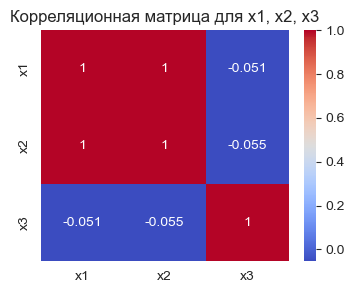

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['x1', 'x2', 'x3']].corr()
print("Корреляционная матрица:")
print(corr)

plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица для x1, x2, x3")
plt.show()

### 1.3 VIF (Variance Inflation Factor)

**Что такое VIF и зачем он нужен?**
- VIF показывает, насколько признак увеличивает дисперсию оценок коэффициентов в линейной регрессии из-за мультиколлинеарности.
- Для каждого признака $x_i$ вычисляется коэффициент детерминации $R_i^2$ при регрессии $x_i$ на все остальные признаки:
  $$
    x_i = \beta_0 + \sum_{j \neq i} \beta_j x_j + \varepsilon.
  $$
- Затем вычисляется
  $$
    \text{VIF}_i = \frac{1}{1 - R_i^2}.
  $$
- Если $R_i^2$ близко к 1 (признак $x_i$ хорошо предсказывается остальными признаками), то VIF становится большим.

**Интерпретация VIF:**
- $\text{VIF} = 1$ означает отсутствие корреляции с другими признаками.
- $\text{VIF} > 5$ (или некоторые рекомендуют >10) указывает на сильную мультиколлинеарность и потенциальные проблемы с оценками коэффициентов.
- Чем выше VIF, тем менее надежны оценки соответствующего коэффициента в линейной регрессии.


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['x1', 'x2', 'x3']].values
vif_data = pd.DataFrame({
    'feature': ['x1', 'x2', 'x3'],
    'VIF': [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})
print("VIF для каждого признака:")
vif_data


VIF для каждого признака:


,feature,VIF
0,x1,896.228508
1,x2,894.711237
2,x3,2.225174


### 1.4 Условное число (Condition Number)

**Что такое условное число и зачем оно нужно?**
- Матрица $X^TX$ характеризует прямую систему нормальных уравнений для линейной регрессии.
- Условное число (condition number) вычисляется как отношение максимального собственного значения $\lambda_{\max}$ матрицы $X^TX$ к минимальному собственному значению $\lambda_{\min}$:
  $$
    \kappa(X^TX) = \frac{\lambda_{\max}}{\lambda_{\min}}.
  $$
- Если $\kappa$ велико (обычно говорят, что порог ~30–100), это означает, что матрица близка к вырождению (чем выше $\kappa$, тем хуже обусловленность).
- В плохо обусловленных системах даже небольшие шумы в данных приводят к большим погрешностям в вычислении коэффициентов.

In [16]:
eigenvalues = np.linalg.eigvals(np.dot(X.T, X))
cond_number = np.max(eigenvalues) / np.min(eigenvalues)
print("Условное число матрицы X^TX:", cond_number)

Условное число матрицы X^TX: 4825.118404416437


### 1.5 Способы устранения мультиколлинеарности без регуляризации

1. **Отбор признаков вручную**
   - Удалить один из пары сильно коррелированных признаков, оставив тот, который более значим с точки зрения таргета.
   - Пример: из двух похожих признаков "площадь кухни" и "общая площадь" оставить только "общая площадь".

2. **Principal Component Analysis (PCA)**
   - PCA преобразует набор коррелированных признаков в новый набор некоррелированных (главных компонент), упорядоченных по величине объясняемой дисперсии.
   - Формально: матрица $X$ проецируется на собственные векторы ковариационной матрицы.
   - Минус: теряется прямая интерпретация исходных признаков.

3. **SVD (Singular Value Decomposition) или Gram-Schmidt**
   - SVD разлагает $X = U \Sigma V^T$, где столбцы $V$ — ортонормированные базисы в пространстве признаков.
   - Gram-Schmidt позволяет построить ортонормированный базис по векторам признаков напрямую, исключая линейные зависимости.

Во всех случаях цель — избавиться от линейных зависимостей между признаками.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Удаление x2
X_reduced = df[['x1', 'x3']].values
lr_reduced = LinearRegression().fit(X_reduced, df['y'])
print("Коэффициенты после удаления x2:", lr_reduced.coef_)

# PCA для x1 и x2 -> 1 компонент
pca = PCA(n_components=1)
pc12 = pca.fit_transform(df[['x1', 'x2']])
X_pca = np.hstack([pc12, df[['x3']].values])
lr_pca = LinearRegression().fit(X_pca, df['y'])
print("Коэффициенты для (PC12, x3):", lr_pca.coef_)

Коэффициенты после удаления x2: [2.95664061 1.98060116]
Коэффициенты для (PC12, x3): [2.09747744 1.98584931]


## 2. Масштабирование признаков

Масштабирование признаков необходимо, чтобы признаки с разными величинами не доминировали при оптимизации и чтобы регуляризация корректно штрафовала параметры.
Например, если один признак измеряется в тысячах, а другой — в сотнях тысяч, оптимизация может "скакать" по направлению большого признака, а регуляризация не будет равномерно применять штраф.

### 2.1 Основные методы масштабирования

1. **StandardScaler (Z-score)**
   - Формула:
     $$
       x_{	ext{scaled}} = \frac{x - \mu}{\sigma},
     $$
     где $\mu$ — среднее по признаку, $\sigma$ — стандартное отклонение.
     $$
        \mu = \frac{1}{n}\sum_{i=1}^{n} x_i
    $$
    $$
        \sigma = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2}
    $$
   - После применения среднее признака становится 0, а стандартное отклонение — 1.
   - Подходит, если распределение признака примерно нормальное, но работает и с другим.

2. **MinMaxScaler**
   - Формула:
     $$
       x_{	ext{scaled}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}.
     $$
   - Приводит данные в диапазон [0, 1].
   - Чувствителен к выбросам: если в данных есть экстремальные значения, они сильно "сжимают" весь диапазон.

3. **RobustScaler**
   - Формула:
     $$
       x_{	ext{scaled}} = \frac{x - \text{median}(x)}{\text{IQR}(x)},
     $$
     где IQR = 75-й перцентиль − 25-й перцентиль.
   - Менее чувствителен к выбросам, так как использует медиану и межквартильный размах.

4. **MaxAbsScaler**
   - Формула:
     $$
       x_{	ext{scaled}} = \frac{x}{\max|x|},
     $$
   - Преобразует данные в диапазон [-1, 1].
   - Сохраняет разреженность (sparsity) в случае разреженных матриц (tf-idf и др.).

**Когда масштабировать:**
- Перед применением регуляризованных моделей (Ridge, Lasso, ElasticNet) обязательно.
- Перед алгоритмами, основанными на расстояниях (KNN, SVM, k-means).
- Перед обучением нейронных сетей, чтобы ускорить сходимость и избежать "взрывных" или "затухающих" градиентов.

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Разделение на train/test
X_full = df[['x1', 'x2', 'x3']].values
y_full = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# 1) Без масштабирования
ridge_none = Ridge(alpha=1.0).fit(X_train, y_train)
coef_none = ridge_none.coef_

# 2) StandardScaler
scaler_std = StandardScaler().fit(X_train)
X_train_std = scaler_std.transform(X_train)
X_test_std = scaler_std.transform(X_test)
ridge_std = Ridge(alpha=1.0).fit(X_train_std, y_train)
coef_std = ridge_std.coef_

# 3) MinMaxScaler
scaler_mm = MinMaxScaler().fit(X_train)
X_train_mm = scaler_mm.transform(X_train)
X_test_mm = scaler_mm.transform(X_test)
ridge_mm = Ridge(alpha=1.0).fit(X_train_mm, y_train)
coef_mm = ridge_mm.coef_

pd.DataFrame({
    'Без масштабирования': coef_none,
    'StandardScaler': coef_std,
    'MinMaxScaler': coef_mm
}, index=['x1', 'x2', 'x3'])

,Без масштабирования,StandardScaler,MinMaxScaler
x1,1.475500,0.529602,1.476866
x2,1.369390,0.294740,1.361355
x3,1.801722,0.561631,1.796499


### 2.2 Типичные ошибки при масштабировании

- **Утечка данных (Data Leakage)**: использовать весь датасет (train + test) для обучения scaler'а.
  - Правильно: вычислять параметры масштабирования ($\mu$, $\sigma$, $x_{\min}$, $x_{\max}$) только на обучающей выборке и применять к тестовой.

- **Масштабирование dummy-переменных (one-hot encoded)**: после one-hot признаки принимают значения 0 или 1, масштабирование бессмысленно.
- **Неправильный выбор метода**:
  - MinMaxScaler при наличии выбросов − сильное "сжатие" основного диапазона.
  - StandardScaler при сильно скошенных распределениях может не вернуть распределение к нормальному виду, но чаще всего всё равно полезен.

## 3. Регуляризация

Регуляризация — это введение дополнительного штрафа в функцию потерь, направленного на ограничение величины коэффициентов модели.
Цели регуляризации:
- Уменьшить переобучение (overfitting) за счет ограничения "сложности" модели.
- Сгладить оценки коэффициентов при наличии мультиколлинеарности.

Рассмотрим три основных подхода в линейных моделях:
1. **Ridge (L2-регуляризация)**
2. **Lasso (L1-регуляризация)**
3. **ElasticNet (смешанная L1 + L2)**

### 3.1 Формулы регуляризации

1. **Ridge (L2-регуляризация)**
   При минимизации функции потерь добавляется штраф:
   $$
     L(w) = \sum_{i=1}^n (y_i - w^T x_i)^2 + \lambda \sum_{j=1}^p w_j^2.
   $$
   - $\lambda \ge 0$ — гиперпараметр штрафа.
   - Чем больше $\lambda$, тем сильнее коэффициенты сжимаются к нулю, но они редко становятся точно нулевыми.

2. **Lasso (L1-регуляризация)**
   $$
     L(w) = \sum_{i=1}^n (y_i - w^T x_i)^2 + \lambda \sum_{j=1}^p |w_j|.
   $$
   - $L1$-шраф заставляет часть коэффициентов становиться ровно нулём, что даёт автоматический отбор признаков.
   - При наличии сильно коррелированных признаков Lasso может "вычёркивать" один из группы, но не гарантирует выбор "правильного" с точки зрения домена.

3. **ElasticNet**
   Комбинирует L1 и L2:
   $$
     L(w) = \sum_{i=1}^n (y_i - w^T x_i)^2 + \alpha \, [\rho \sum_{j=1}^p |w_j| + (1 - \rho) \sum_{j=1}^p w_j^2 ].
   $$
   - $\alpha$ — общая сила штрафа.
   - $\rho$ (или `l1_ratio`) — доля $L1$-шрафа в общей регуляризации.
   - ElasticNet сочетает свойства Lasso (способность обнулять коэффициенты) и Ridge (устойчивость при коррелированных признаках).


In [19]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Предполагается, что X_train_std и y_train уже определены (из раздела масштабирования)

# 1) Ridge
param_grid_ridge = {'alpha': np.logspace(-3, 2, 10)}
ridge_cv = GridSearchCV(Ridge(), param_grid_ridge, cv=5)
ridge_cv.fit(X_train_std, y_train)
best_ridge = ridge_cv.best_estimator_
coef_ridge = best_ridge.coef_
alpha_ridge = ridge_cv.best_params_['alpha']

# 2) Lasso
param_grid_lasso = {'alpha': np.logspace(-3, 1, 10)}
lasso_cv = GridSearchCV(Lasso(max_iter=10000), param_grid_lasso, cv=5)
lasso_cv.fit(X_train_std, y_train)
best_lasso = lasso_cv.best_estimator_
coef_lasso = best_lasso.coef_
alpha_lasso = lasso_cv.best_params_['alpha']

# 3) ElasticNet
param_grid_enet = {
    'alpha': np.logspace(-3, 1, 5),
    'l1_ratio': [0.2, 0.5, 0.8]
}
enet_cv = GridSearchCV(ElasticNet(max_iter=10000), param_grid_enet, cv=5)
enet_cv.fit(X_train_std, y_train)
best_enet = enet_cv.best_estimator_
coef_enet = best_enet.coef_
alpha_enet = enet_cv.best_params_

pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'ElasticNet'],
    'Best Alpha(s)': [alpha_ridge, alpha_lasso, alpha_enet],
    'Coefficients': [coef_ridge, coef_lasso, coef_enet]
})

,Model,Best Alpha(s),Coefficients
0,Ridge,0.001,"[0.8570689873732127, -0.029682692415560173, 0...."
1,Lasso,0.002783,"[0.8245772306064648, 0.0, 0.5612553061287288]"
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.8}","[0.8264699844120054, 2.9767461495976485e-06, 0..."


### 3.2 Путь коэффициентов (Coefficient Path)

Путь коэффициентов показывает, как значения весов (коэффициентов) меняются при различных значениях $\alpha$ (или $\lambda$). Это помогает понять, какие признаки "уходят" в ноль первыми (для Lasso) или как сильно сжимаются (для Ridge).

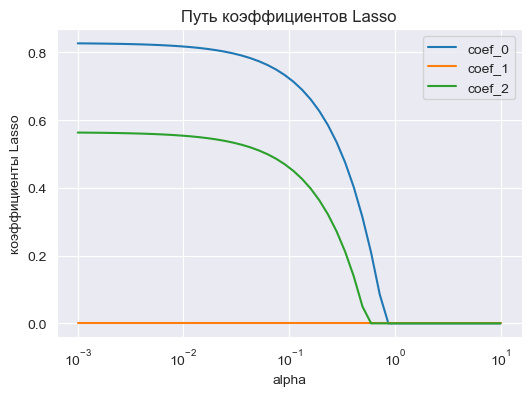

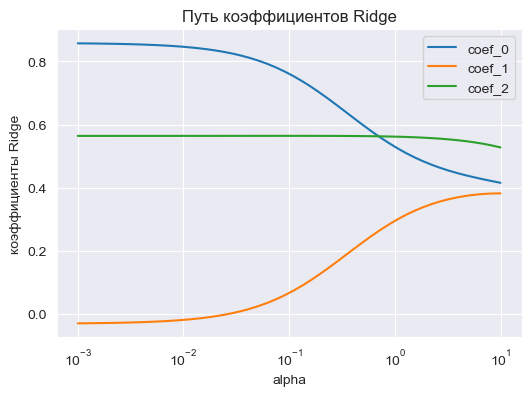

In [20]:
import matplotlib.pyplot as plt

alphas = np.logspace(-3, 1, 50)
coefs_lasso_path = []
coefs_ridge_path = []

for a in alphas:
    l = Lasso(alpha=a, max_iter=10000).fit(X_train_std, y_train)
    r = Ridge(alpha=a).fit(X_train_std, y_train)
    coefs_lasso_path.append(l.coef_)
    coefs_ridge_path.append(r.coef_)

coefs_lasso_path = np.array(coefs_lasso_path)
coefs_ridge_path = np.array(coefs_ridge_path)

# Lasso path
plt.figure(figsize=(6, 4))
for i in range(coefs_lasso_path.shape[1]):
    plt.plot(alphas, coefs_lasso_path[:, i], label=f'coef_{i}')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('коэффициенты Lasso')
plt.title('Путь коэффициентов Lasso')
plt.legend(loc='best')
plt.show()

# Ridge path
plt.figure(figsize=(6, 4))
for i in range(coefs_ridge_path.shape[1]):
    plt.plot(alphas, coefs_ridge_path[:, i], label=f'coef_{i}')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('коэффициенты Ridge')
plt.title('Путь коэффициентов Ridge')
plt.legend(loc='best')
plt.show()

### 3.3 Важные замечания о масштабировании и регуляризации

- **Регуляризация без масштабирования бессмысленна**
  L1 и L2 штрафы основаны на абсолютных или квадратичных значениях коэффициентов. Если признак в большем масштабе, его коэффициент будет "меньше" в штрафе, и наоборот.

- **Выбор гиперпараметра**
  - $\alpha = 0$ → обычная линейная регрессия, риск переобучения.
  - $\alpha \to \infty$ → все коэффициенты стремятся к нулю, модель недообучена.
  - Ищем "золотую середину" через кросс-валидацию (GridSearchCV).

- **Поведение при мультиколлинеарности**
  - Ridge: "размазывает" вес между слабо коррелированными признаками.
  - Lasso: обнуляет некоторые коэффициенты, но при коррелированных признаках выбор может быть непредсказуем.
  - ElasticNet: балансирует между обнулением и сжатием признаков.

## 4. Полный пример-пайплайн на реальных данных (California Housing)

Загрузим датасет California Housing из sklearn и проведём следующие шаги:
1. EDA → матрица корреляций, VIF.
2. Выбор наиболее проблемных признаков (удаление при необходимости).
3. Масштабирование признаков.
4. Обучение LinearRegression без регуляризации.
5. Обучение Ridge и Lasso.
6. Сравнение результатов по MSE и $R^2$.

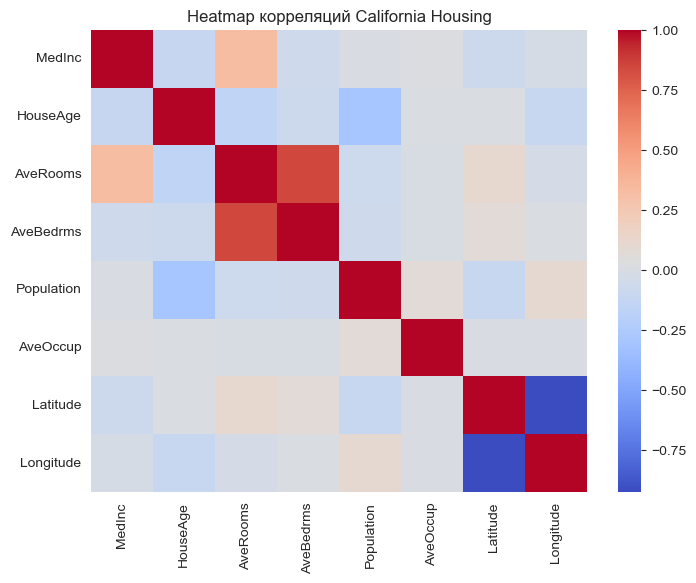

VIF для признаков California Housing:
      feature         VIF
7   Longitude  633.711654
6    Latitude  559.874071
2    AveRooms   45.993601
3   AveBedrms   43.590314
0      MedInc   11.511140
1    HouseAge    7.195917
4  Population    2.935745
5    AveOccup    1.095243
Сравнение моделей:
              Model       MSE        R2
0            Linear  0.530568  0.595770
1  Ridge(alpha=1.0)  0.530544  0.595789
2  Lasso(alpha=0.1)  0.664812  0.493492


In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 1) Загрузка
data = fetch_california_housing(as_frame=True)
X_raw = data.data
y_raw = data.target

# 2) EDA: Корреляционная матрица
corr_cal = X_raw.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_cal, annot=False, cmap='coolwarm')
plt.title("Heatmap корреляций California Housing")
plt.show()

# 3) VIF
X_arr = X_raw.values
vif_cal = pd.DataFrame({
    'feature': X_raw.columns,
    'VIF': [variance_inflation_factor(X_arr, i) for i in range(X_arr.shape[1])]
}).sort_values(by='VIF', ascending=False)
print("VIF для признаков California Housing:")
print(vif_cal)

# 4) Train/Test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)

# 5) Масштабирование
scaler_full = StandardScaler().fit(X_train_raw)
X_train = scaler_full.transform(X_train_raw)
X_test = scaler_full.transform(X_test_raw)

# 6) Linear Regression без регуляризации
lr_base = LinearRegression().fit(X_train, y_train)
y_pred_base = lr_base.predict(X_test)
mse_base = mean_squared_error(y_test, y_pred_base)
r2_base = r2_score(y_test, y_pred_base)

# 7) Ridge (alpha=1.0)
ridge_model = Ridge(alpha=1.0).fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# 8) Lasso (alpha=0.1)
lasso_model = Lasso(alpha=0.1, max_iter=10000).fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# 9) Результаты
results = pd.DataFrame({
    'Model': ['Linear', 'Ridge(alpha=1.0)', 'Lasso(alpha=0.1)'],
    'MSE': [mse_base, mse_ridge, mse_lasso],
    'R2': [r2_base, r2_ridge, r2_lasso]
})
print("Сравнение моделей:")
print(results)

### 4.1 Анализ результатов

В результирующей таблице представлены значения MSE и $R^2$ для моделей:
- **Linear:** базовая линейная регрессия без регуляризации.
- **Ridge (alpha=1.0):** линейная регрессия с L2-регуляризацией.
- **Lasso (alpha=0.1):** линейная регрессия с L1-регуляризацией.

**На что обратить внимание:**
- Как изменились MSE и $R^2$ после добавления регуляризации.
- Удалось ли Ridge снизить дисперсию и улучшить обобщающую способность.
- Какие признаки обнулила Lasso (можно посмотреть `lasso_model.coef_`) и как это повлияло на метрики.


## 5. Заключение и будущее

- **Выводы:**
  - Мультиколлинеарность: выявляется через VIF и условное число, приводит к нестабильным оценкам.
  - Масштабирование: обязательный шаг перед регуляризацией и в алгоритмах, чувствительных к масштабам.
  - Регуляризация (Ridge, Lasso, ElasticNet): помогает контролировать сложность модели, но требует понимания:
    - Ridge "размазывает" вес между коррелированными признаками.
    - Lasso обнуляет часть признаков, выбор из коррелированных групп может быть непредсказуем.
    - ElasticNet сочетает преимущества обоих.

- **Будущее:**
  - **Bayesian регуляризация (Bayesian Lasso, Spike-and-Slab):** более "прозрачная" интерпретация с распределениями весов.
  - **Group Lasso, Sparse Group Lasso:** штраф по группам признаков, полезно при логически связанных фичах.
  - **AutoML:** автоматический подбор методов масштабирования и регуляризации, но часто без объяснения "почему" выбран тот или иной метод.